In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_again', 'X_train.npy'))
    labels = np.load(os.path.join('Data_again', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_again', 'X_test.npy'))
    labels = np.load(os.path.join('Data_again', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([3, 0, 2, 2, 0, 2, 2, 2, 0, 3, 0, 0, 1, 3, 3, 0, 1, 1, 1, 2, 2, 2,
       1, 0, 0, 1, 1, 3, 0, 1, 3, 2, 2, 1, 3, 3, 1, 1, 3, 0, 3, 0, 0, 2,
       2, 3, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 3, 0, 2, 2, 2, 1, 3, 1, 0,
       2, 0, 3, 1, 2, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1, 1, 3, 0, 3, 3, 0, 0,
       3, 1, 0, 2, 2, 0, 2, 3, 3, 0, 2, 0, 0, 0, 0, 1, 1, 1, 3, 3, 1, 1,
       3, 3, 2, 0, 0, 0, 2, 3, 3, 0, 0, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 2, 2, 2, 1, 2, 2, 3, 0, 3, 1, 0, 0, 1, 0, 1, 2, 1, 3, 0,
       0, 3, 0, 1, 2, 2, 1, 0, 1, 3, 1, 3, 1, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 2, 2, 3, 3, 1, 1, 0, 1, 2, 1, 2, 0, 3, 2, 2, 2, 2, 0, 1, 1, 3,
       2, 0, 2, 2, 1, 3, 2, 2, 3, 2, 0, 1, 3, 1, 0, 1, 0, 3, 3, 1, 0, 1,
       2, 3, 2, 1, 0, 3, 3, 0, 0, 0, 0, 1, 2, 1, 1, 3, 3, 3, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 3, 0, 0, 1, 0, 3, 2, 3, 2, 0, 2, 3, 0, 0, 0, 0, 0,
       3, 1, 2, 1, 0, 0, 3, 0, 1, 0, 2, 3, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0,
       3, 0, 3, 1, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 3,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

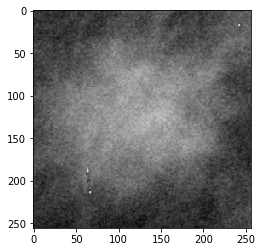

Label: [0. 0. 0. 1.]
[[[ 71.46875     71.46875     71.46875   ]
  [ 73.25        73.25        73.25      ]
  [ 71.80078125  71.80078125  71.80078125]
  ...
  [185.5703125  185.5703125  185.5703125 ]
  [183.57421875 183.57421875 183.57421875]
  [187.05859375 187.05859375 187.05859375]]

 [[ 73.359375    73.359375    73.359375  ]
  [ 77.953125    77.953125    77.953125  ]
  [ 73.671875    73.671875    73.671875  ]
  ...
  [182.7734375  182.7734375  182.7734375 ]
  [179.05859375 179.05859375 179.05859375]
  [183.87109375 183.87109375 183.87109375]]

 [[ 73.5         73.5         73.5       ]
  [ 77.5390625   77.5390625   77.5390625 ]
  [ 74.71875     74.71875     74.71875   ]
  ...
  [180.41796875 180.41796875 180.41796875]
  [181.3828125  181.3828125  181.3828125 ]
  [182.59765625 182.59765625 182.59765625]]

 ...

 [[144.7265625  144.7265625  144.7265625 ]
  [149.96484375 149.96484375 149.96484375]
  [146.26171875 146.26171875 146.26171875]
  ...
  [190.03125    190.03125    190.03125  

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 789

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

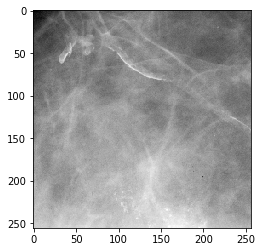

Label: [0. 0. 1. 0.]
[[[ 71.46875     71.46875     71.46875   ]
  [ 73.25        73.25        73.25      ]
  [ 71.80078125  71.80078125  71.80078125]
  ...
  [185.5703125  185.5703125  185.5703125 ]
  [183.57421875 183.57421875 183.57421875]
  [187.05859375 187.05859375 187.05859375]]

 [[ 73.359375    73.359375    73.359375  ]
  [ 77.953125    77.953125    77.953125  ]
  [ 73.671875    73.671875    73.671875  ]
  ...
  [182.7734375  182.7734375  182.7734375 ]
  [179.05859375 179.05859375 179.05859375]
  [183.87109375 183.87109375 183.87109375]]

 [[ 73.5         73.5         73.5       ]
  [ 77.5390625   77.5390625   77.5390625 ]
  [ 74.71875     74.71875     74.71875   ]
  ...
  [180.41796875 180.41796875 180.41796875]
  [181.3828125  181.3828125  181.3828125 ]
  [182.59765625 182.59765625 182.59765625]]

 ...

 [[144.7265625  144.7265625  144.7265625 ]
  [149.96484375 149.96484375 149.96484375]
  [146.26171875 146.26171875 146.26171875]
  ...
  [190.03125    190.03125    190.03125  

In [13]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 5

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))

print(train_images[0])

In [14]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(output, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

vgg16_fe_drop_temp.summary()

In [26]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128, output = 4)

In [27]:
vgg16_fe_drop_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 48,401,860
Trainable params: 33,687,172
Non-trainable params: 14,714,688
___________________________________

In [28]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [29]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 2.8509 - accuracy: 0.3531
Epoch 00001: val_loss improved from inf to 1.39872, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 24s 2s/step - loss: 2.7611 - accuracy: 0.3558 - val_loss: 1.3987 - val_accuracy: 0.4003
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4120 - accuracy: 0.4606
Epoch 00002: val_loss improved from 1.39872 to 1.16828, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 20s 2s/step - loss: 1.3774 - accuracy: 0.4667 - val_loss: 1.1683 - val_accuracy: 0.4863
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3213 - accuracy: 0.4727
Epoch 00003: val_loss improved from 1.16828 to 1.15690, saving model to vgg16_fe_drop_128_

11/11 [==============================] - 21s 2s/step - loss: 0.9700 - accuracy: 0.5800 - val_loss: 0.9072 - val_accuracy: 0.6048
Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9760 - accuracy: 0.5802
Epoch 00028: val_loss did not improve from 0.90724
11/11 [==============================] - 21s 2s/step - loss: 0.9882 - accuracy: 0.5715 - val_loss: 0.9310 - val_accuracy: 0.5859
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9760 - accuracy: 0.5648
Epoch 00029: val_loss did not improve from 0.90724
11/11 [==============================] - 22s 2s/step - loss: 0.9746 - accuracy: 0.5696 - val_loss: 0.9271 - val_accuracy: 0.5687
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9321 - accuracy: 0.5844
Epoch 00030: val_loss did not improve from 0.90724
11/11 [==============================] - 21s 2s/step - loss: 0.9473 - accuracy: 0.5781 - val_loss: 0.9969 - val_accuracy: 0.5241
Epoch 31/300
10/11 [=======================

Epoch 86/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9112 - accuracy: 0.6132
Epoch 00086: val_loss did not improve from 0.85504
11/11 [==============================] - 21s 2s/step - loss: 0.9172 - accuracy: 0.6090 - val_loss: 0.8931 - val_accuracy: 0.6271
Epoch 87/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8766 - accuracy: 0.6211
Epoch 00087: val_loss did not improve from 0.85504
11/11 [==============================] - 23s 2s/step - loss: 0.8771 - accuracy: 0.6165 - val_loss: 0.8619 - val_accuracy: 0.6203
Epoch 88/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9097 - accuracy: 0.5988
Epoch 00088: val_loss did not improve from 0.85504
11/11 [==============================] - 21s 2s/step - loss: 0.9114 - accuracy: 0.5983 - val_loss: 0.9231 - val_accuracy: 0.6031
Epoch 89/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8966 - accuracy: 0.6086
Epoch 00089: val_loss improved from 0.85504 to 0.85250, saving model to vgg1

10/11 [==========================>...] - ETA: 1s - loss: 0.8871 - accuracy: 0.6200
Epoch 00144: val_loss did not improve from 0.83207
11/11 [==============================] - 22s 2s/step - loss: 0.8863 - accuracy: 0.6167 - val_loss: 0.9017 - val_accuracy: 0.5962
Epoch 145/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8510 - accuracy: 0.6391
Epoch 00145: val_loss did not improve from 0.83207
11/11 [==============================] - 23s 2s/step - loss: 0.8419 - accuracy: 0.6392 - val_loss: 0.9145 - val_accuracy: 0.5722
Epoch 146/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8370 - accuracy: 0.6565
Epoch 00146: val_loss did not improve from 0.83207
11/11 [==============================] - 21s 2s/step - loss: 0.8231 - accuracy: 0.6626 - val_loss: 0.9080 - val_accuracy: 0.6117
Epoch 147/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8087 - accuracy: 0.6531
Epoch 00147: val_loss did not improve from 0.83207
11/11 [============================

In [30]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [31]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [32]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [33]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 165
Epoch [opt]: 135
Valid accuracy [end]: 0.6151
Valid accuracy [opt]: 0.6014
Test accuracy [end]:  0.6183
Test accuracy [opt]:  0.6031
Valid loss [end]: 0.8767
Valid loss [opt]: 0.8321
Test loss [end]:  0.9291
Test loss [opt]:  0.9578


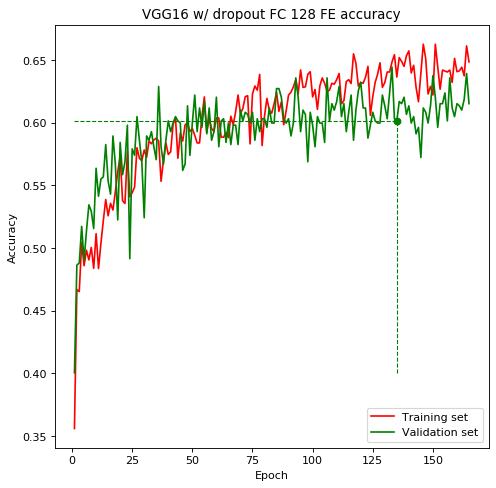

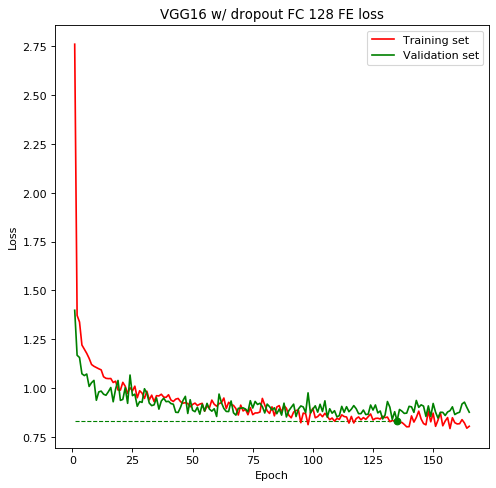

In [34]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [35]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256, output=4)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 2.5372 - accuracy: 0.2746
Epoch 00001: val_loss improved from inf to 1.56971, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 2.5017 - accuracy: 0.2784 - val_loss: 1.5697 - val_accuracy: 0.4107
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.9921 - accuracy: 0.3727
Epoch 00002: val_loss improved from 1.56971 to 1.40765, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.9845 - accuracy: 0.3758 - val_loss: 1.4076 - val_accuracy: 0.4433
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.8584 - accuracy: 0.3917
Epoch 00003: val_loss improved from 1.40765 to 1.38195, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.8

19/19 [==============================] - 31s 2s/step - loss: 1.2351 - accuracy: 0.4955 - val_loss: 1.0649 - val_accuracy: 0.5344
Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2179 - accuracy: 0.4852
Epoch 00028: val_loss improved from 1.06490 to 1.04383, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.2179 - accuracy: 0.4839 - val_loss: 1.0438 - val_accuracy: 0.5361
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2153 - accuracy: 0.4948
Epoch 00029: val_loss did not improve from 1.04383
19/19 [==============================] - 30s 2s/step - loss: 1.2071 - accuracy: 0.4964 - val_loss: 1.0523 - val_accuracy: 0.5481
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2083 - accuracy: 0.5052
Epoch 00030: val_loss improved from 1.04383 to 1.02170, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.2317 - 

Epoch 57/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1217 - accuracy: 0.5329
Epoch 00057: val_loss improved from 0.99353 to 0.97069, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.1198 - accuracy: 0.5302 - val_loss: 0.9707 - val_accuracy: 0.5567
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0714 - accuracy: 0.5379
Epoch 00058: val_loss did not improve from 0.97069
19/19 [==============================] - 30s 2s/step - loss: 1.0753 - accuracy: 0.5371 - val_loss: 1.0093 - val_accuracy: 0.5447
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1061 - accuracy: 0.5120
Epoch 00059: val_loss did not improve from 0.97069
19/19 [==============================] - 30s 2s/step - loss: 1.1089 - accuracy: 0.5131 - val_loss: 1.0169 - val_accuracy: 0.5223
Epoch 60/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0771 - accuracy: 0.5297
Epoch 00060: val_loss imp

Epoch 115/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0113 - accuracy: 0.5588
Epoch 00115: val_loss did not improve from 0.91670
19/19 [==============================] - 31s 2s/step - loss: 1.0142 - accuracy: 0.5573 - val_loss: 0.9392 - val_accuracy: 0.5756
Epoch 116/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9907 - accuracy: 0.5579
Epoch 00116: val_loss did not improve from 0.91670
19/19 [==============================] - 31s 2s/step - loss: 0.9912 - accuracy: 0.5573 - val_loss: 0.9641 - val_accuracy: 0.5533
Epoch 117/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0033 - accuracy: 0.5570
Epoch 00117: val_loss did not improve from 0.91670
19/19 [==============================] - 31s 2s/step - loss: 1.0080 - accuracy: 0.5530 - val_loss: 0.9345 - val_accuracy: 0.5808
Epoch 118/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0032 - accuracy: 0.5529
Epoch 00118: val_loss did not improve from 0.91670
19/19 [==============

In [37]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [38]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 150
Epoch [opt]: 143
Valid accuracy [end]: 0.5808
Valid accuracy [opt]: 0.6151
Test accuracy [end]:  0.5939
Test accuracy [opt]:  0.5878
Valid loss [end]: 0.9171
Valid loss [opt]: 0.9016
Test loss [end]:  0.9379
Test loss [opt]:  0.9463


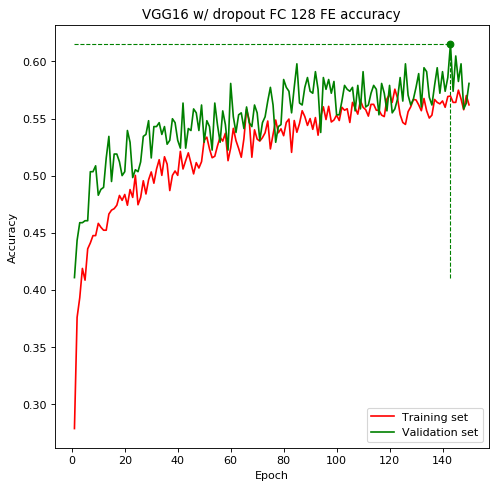

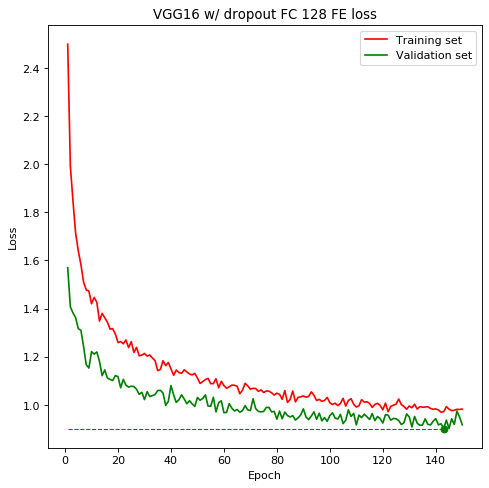

In [39]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [15]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 48,401,860
Trainable params: 33,687,172
Non-trainable params: 14,714,688
___________________________________

In [16]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 48,401,860
Trainable params: 36,046,980
Non-trainable params: 12,354,880
___________________________________

In [17]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [18]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 1.0713 - accuracy: 0.5776
Epoch 00001: val_loss improved from inf to 0.84194, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 26s 2s/step - loss: 1.0514 - accuracy: 0.5777 - val_loss: 0.8419 - val_accuracy: 0.6357
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8780 - accuracy: 0.6209
Epoch 00002: val_loss improved from 0.84194 to 0.82771, saving model to vgg16_ft_1layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.8638 - accuracy: 0.6266 - val_loss: 0.8277 - val_accuracy: 0.6220
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8639 - accuracy: 0.6175
Epoch 00003: val_loss improved from 0.82771 to 0.82623, saving model to vgg16_ft_1layer_4cl_be

10/11 [==========================>...] - ETA: 1s - loss: 0.7723 - accuracy: 0.6726
Epoch 00028: val_loss did not improve from 0.80194
11/11 [==============================] - 21s 2s/step - loss: 0.7769 - accuracy: 0.6702 - val_loss: 0.8743 - val_accuracy: 0.6409
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7352 - accuracy: 0.6742
Epoch 00029: val_loss did not improve from 0.80194
11/11 [==============================] - 22s 2s/step - loss: 0.7222 - accuracy: 0.6797 - val_loss: 0.9287 - val_accuracy: 0.6203
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7709 - accuracy: 0.6548
Epoch 00030: val_loss did not improve from 0.80194
11/11 [==============================] - 20s 2s/step - loss: 0.7662 - accuracy: 0.6603 - val_loss: 0.8725 - val_accuracy: 0.6495
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.7728 - accuracy: 0.6760
Epoch 00031: val_loss did not improve from 0.80194
11/11 [==============================]

In [19]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [20]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 36
Epoch [opt]: 6
Valid accuracy [end]: 0.6443
Valid accuracy [opt]: 0.6323
Test accuracy [end]:  0.5969
Test accuracy [opt]:  0.6076
Valid loss [end]: 0.9157
Valid loss [opt]: 0.8019
Test loss [end]:  0.9383
Test loss [opt]:  0.9420


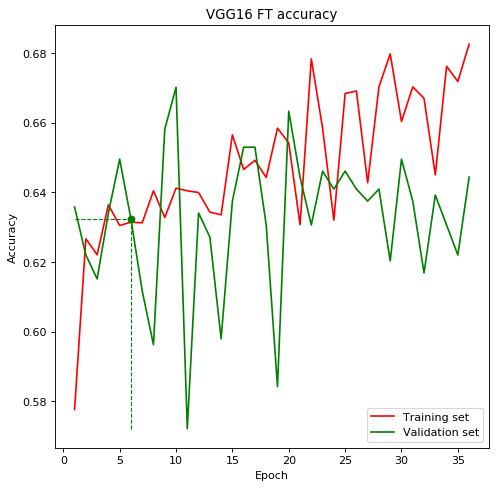

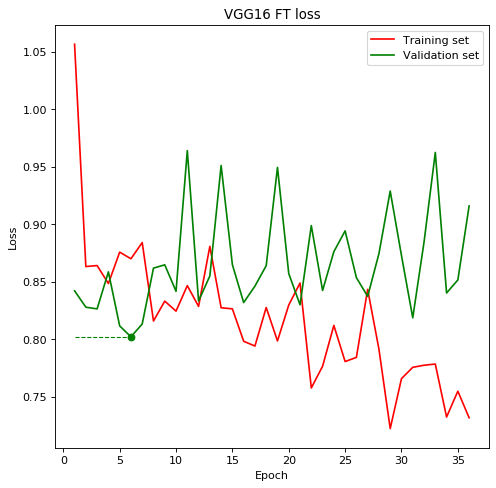

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [22]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 48,401,860
Trainable params: 38,406,788
Non-trainable params: 9,995,072
____________________________________

In [23]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [24]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 0.8155 - accuracy: 0.6391
Epoch 00001: val_loss improved from inf to 0.80923, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 0.8190 - accuracy: 0.6364 - val_loss: 0.8092 - val_accuracy: 0.6443
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7956 - accuracy: 0.6556
Epoch 00002: val_loss improved from 0.80923 to 0.79218, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 0.7955 - accuracy: 0.6542 - val_loss: 0.7922 - val_accuracy: 0.6684
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7989 - accuracy: 0.6484
Epoch 00003: val_loss did not improve from 0.79218
11/11 [==============================] - 22s 2s/step - loss: 0.8071 - accuracy: 0.6477 - val_loss: 0.8185 - val_accurac

Epoch 29/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7844 - accuracy: 0.6469
Epoch 00029: val_loss did not improve from 0.77117
11/11 [==============================] - 22s 2s/step - loss: 0.7795 - accuracy: 0.6513 - val_loss: 0.7918 - val_accuracy: 0.6564
Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7165 - accuracy: 0.6828
Epoch 00030: val_loss improved from 0.77117 to 0.76686, saving model to vgg16_ft_2layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7185 - accuracy: 0.6802 - val_loss: 0.7669 - val_accuracy: 0.6684
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7664 - accuracy: 0.6664
Epoch 00031: val_loss did not improve from 0.76686
11/11 [==============================] - 22s 2s/step - loss: 0.7703 - accuracy: 0.6676 - val_loss: 0.7750 - val_accuracy: 0.6838
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7765 - accuracy: 0.6531
Epoch 00032: val_loss did n

10/11 [==========================>...] - ETA: 1s - loss: 0.7310 - accuracy: 0.6692
Epoch 00058: val_loss did not improve from 0.75441
11/11 [==============================] - 21s 2s/step - loss: 0.7157 - accuracy: 0.6809 - val_loss: 0.7907 - val_accuracy: 0.6529
Epoch 59/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7559 - accuracy: 0.6633
Epoch 00059: val_loss did not improve from 0.75441
11/11 [==============================] - 22s 2s/step - loss: 0.7454 - accuracy: 0.6712 - val_loss: 0.8122 - val_accuracy: 0.6426
Epoch 60/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7398 - accuracy: 0.6768
Epoch 00060: val_loss did not improve from 0.75441
11/11 [==============================] - 20s 2s/step - loss: 0.7386 - accuracy: 0.6802 - val_loss: 0.8075 - val_accuracy: 0.6581
Epoch 61/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7572 - accuracy: 0.6768
Epoch 00061: val_loss did not improve from 0.75441
11/11 [==============================]

Epoch 88/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7019 - accuracy: 0.6947
Epoch 00088: val_loss did not improve from 0.71911
11/11 [==============================] - 21s 2s/step - loss: 0.6918 - accuracy: 0.6978 - val_loss: 0.7961 - val_accuracy: 0.6598
Epoch 89/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7150 - accuracy: 0.6797
Epoch 00089: val_loss did not improve from 0.71911
11/11 [==============================] - 22s 2s/step - loss: 0.7163 - accuracy: 0.6783 - val_loss: 0.7844 - val_accuracy: 0.6564
Epoch 90/200
10/11 [==========================>...] - ETA: 1s - loss: 0.6890 - accuracy: 0.6964
Epoch 00090: val_loss did not improve from 0.71911
11/11 [==============================] - 21s 2s/step - loss: 0.6844 - accuracy: 0.6970 - val_loss: 0.8308 - val_accuracy: 0.6581
Epoch 91/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7311 - accuracy: 0.6891
Epoch 00091: val_loss did not improve from 0.71911
11/11 [==================

In [25]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [26]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 95
Epoch [opt]: 65
Valid accuracy [end]: 0.6529
Valid accuracy [opt]: 0.6821
Test accuracy [end]:  0.6015
Test accuracy [opt]:  0.5908
Valid loss [end]: 0.7732
Valid loss [opt]: 0.7191
Test loss [end]:  0.8889
Test loss [opt]:  0.9077


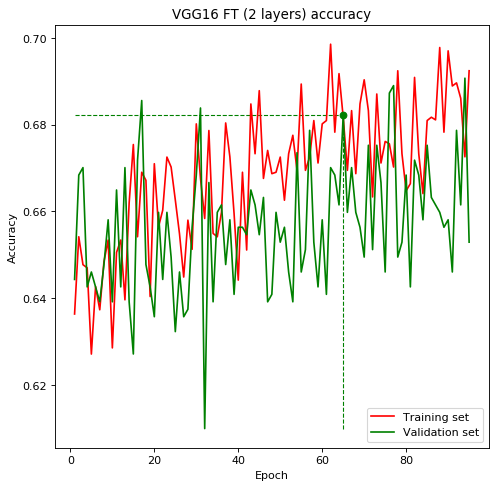

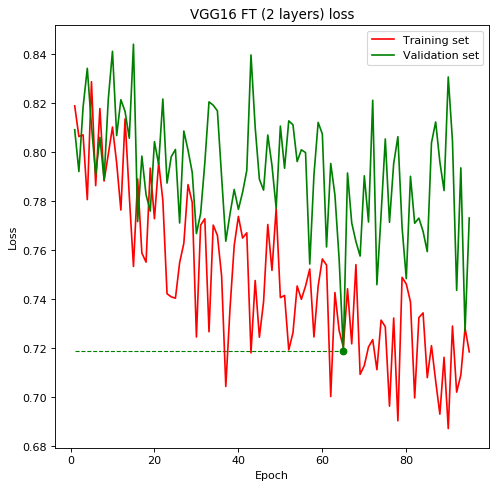

In [27]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [28]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 48,401,860
Trainable params: 40,766,596
Non-trainable params: 7,635,264
____________________________________

In [29]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [30]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/200
10/11 [==========================>...] - ETA: 1s - loss: 0.6945 - accuracy: 0.6938
Epoch 00001: val_loss improved from inf to 0.81361, saving model to vgg16_ft_3layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7116 - accuracy: 0.6863 - val_loss: 0.8136 - val_accuracy: 0.6546
Epoch 2/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7410 - accuracy: 0.6819
Epoch 00002: val_loss improved from 0.81361 to 0.80065, saving model to vgg16_ft_3layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7470 - accuracy: 0.6771 - val_loss: 0.8006 - val_accuracy: 0.6478
Epoch 3/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7064 - accuracy: 0.6845
Epoch 00003: val_loss improved from 0.80065 to 0.76444, saving model to vgg16_ft_3layer_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.7155 - 

Epoch 29/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7332 - accuracy: 0.6802
Epoch 00029: val_loss did not improve from 0.73667
11/11 [==============================] - 20s 2s/step - loss: 0.7270 - accuracy: 0.6825 - val_loss: 0.7749 - val_accuracy: 0.6718
Epoch 30/200
10/11 [==========================>...] - ETA: 1s - loss: 0.6951 - accuracy: 0.6964
Epoch 00030: val_loss did not improve from 0.73667
11/11 [==============================] - 21s 2s/step - loss: 0.7029 - accuracy: 0.6924 - val_loss: 0.7835 - val_accuracy: 0.6546
Epoch 31/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7090 - accuracy: 0.6794
Epoch 00031: val_loss did not improve from 0.73667
11/11 [==============================] - 21s 2s/step - loss: 0.7155 - accuracy: 0.6787 - val_loss: 0.7769 - val_accuracy: 0.6770
Epoch 32/200
10/11 [==========================>...] - ETA: 1s - loss: 0.7245 - accuracy: 0.6573
Epoch 00032: val_loss did not improve from 0.73667
11/11 [==================

In [31]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [32]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 50
Epoch [opt]: 20
Valid accuracy [end]: 0.6838
Valid accuracy [opt]: 0.6649
Test accuracy [end]:  0.6153
Test accuracy [opt]:  0.6137
Valid loss [end]: 0.7774
Valid loss [opt]: 0.7367
Test loss [end]:  0.8510
Test loss [opt]:  0.8815


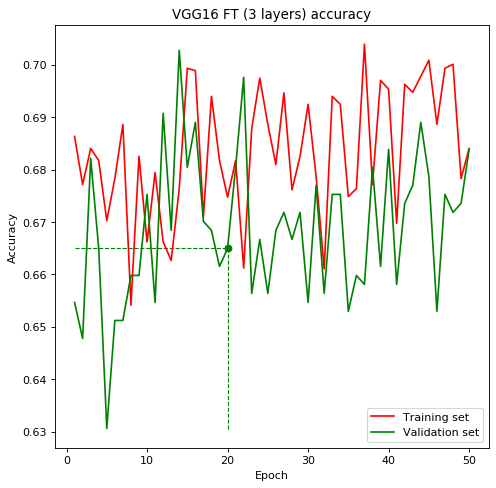

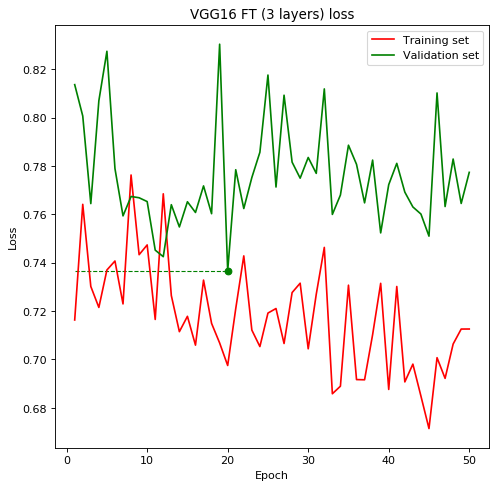

In [33]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();